In [173]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from blahut import blahut_update, weight_step, blahut_update_disc
from scipy.special import gamma # gamma -> gamma function
from scipy.stats import gamma as gamma2 # gamma2 -> gamma distribution

# Importing data

Loading processed data:

In [2]:
with open('processed_data/t.pkl', 'rb') as f:
    t_data = pickle.load(f) # Wnt "on" durations

with open('processed_data/g.pkl', 'rb') as f:
    g_data = pickle.load(f) # Single-cell gene expression levels for each "on" condition

Global parameters:

In [72]:
khat = 2.88 # shape parameter
ahat = 23.03 # hr^-1, linear scaling of scale parameter
tmax = 20.00 # hrs, max experiment time

tau = 20.0/ahat # = 0.87 hrs
epsilon = 19.7/ahat # = 0.86 hrs

def eps(tvec): # scale parameter correction near t=0
    return epsilon*np.exp(-tvec/tau)

def theta(tvec): # scale parameter as a function of "on" duration
    return ahat*(tvec + eps(tvec))

Define gamma distribution:

In [ ]:
tvec = np.linspace(0, tmax, 200).reshape(-1, 1) # time vector
gvec = np.linspace(0, 6000, 1000).reshape(-1, 1) # gene expression vector
dt = (tvec[1] - tvec[0])[0]
dg = (gvec[1] - gvec[0])[0]

T, G = np.meshgrid(theta(tvec), gvec)
p_g_given_t = gamma2.pdf(G, a=khat, scale=T) # gamma fit of likelihood function

# mean and stdev of gamma fit
means = np.matmul(gvec.T, p_g_given_t).T*dg
stdevs = np.sqrt(np.matmul((gvec**2).T, p_g_given_t).T*dg - means**2)

Mean and stdev of data:

In [ ]:
means_data = np.zeros(0)
stdevs_data = np.zeros(0)

for array in g_data:
    means_data = np.append(means_data, np.mean(array))
    stdevs_data = np.append(stdevs_data, np.std(array))

# Fig1

## Fig1A

Experiment schematic: 

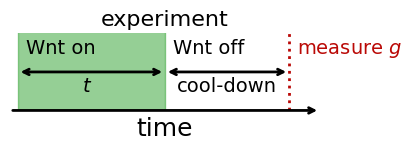

In [39]:
fig, ax = plt.subplots(figsize = (4,1.0), dpi = 100)
cmap = plt.get_cmap('OrRd')
colors = [cmap(0.4), cmap(0.55), cmap(0.7), cmap(0.85)]

ax.fill_between([0.05, 1], 0, 1, color = 'tab:green', alpha = 0.5)
ax.axvline(x=1.8, linestyle='dotted', color=colors[-1], linewidth = 2)

ax.annotate('', xy=(0.05, 0.5), xytext=(1, 0.5), arrowprops=dict(arrowstyle='<->', linewidth=2))
ax.annotate('', xy=(1, 0.5), xytext=(1.8, 0.5), arrowprops=dict(arrowstyle='<->', linewidth=2))
ax.annotate('', xy=(0, 0.2), xytext=(2, 0.2), arrowprops=dict(arrowstyle='<-', linewidth=2))
ax.annotate('Wnt on', xy=(0.1, 0.65), fontsize=14, color = 'black')
ax.annotate('Wnt off', xy=(1.05, 0.65), fontsize=14, color = 'black')
ax.annotate(r'$t$', xy=(0.5, 0.35), fontsize=14, color = 'black', ha='center')
ax.annotate('cool-down', xy=(1.4, 0.35), fontsize=14, color = 'black', ha='center')
ax.annotate(r'measure $g$', xy=(1.85, 0.65), fontsize=14, color = colors[-1])
ax.set_title('experiment', fontsize=16)

ax.set_xlim(0,2)
ax.set_ylim(0.2, 0.8)
ax.set_yticks([])
ax.set_xticks([])
ax.set_xticklabels([], fontsize=18)
ax.tick_params(labelsize=14)
ax.set_xlabel('time', fontsize=18)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.show()

# fig.savefig('figures/Fig1A.pdf', bbox_inches='tight')

## Fig1B 

Data histograms for given $t$: 

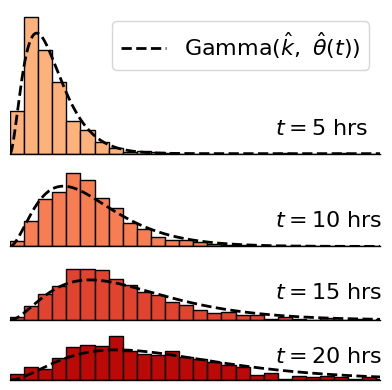

In [168]:
height_ratios = [2.4, 1.3, 0.98, 0.75]

nos = [19, 37, 55, 73]
cmap = plt.get_cmap('OrRd')

colors = [cmap(0.4), cmap(0.55), cmap(0.7), cmap(0.85)]

fig, axs = plt.subplots(len(nos), 1, figsize=(4, 4), sharex=True, gridspec_kw={'height_ratios': height_ratios}, tight_layout=True,dpi=100)

for i in range(len(nos)):
    axs[i].hist(g_data[nos[i]], density=True, bins=35, range=[0, 4000], color = colors[i], ec="black", alpha=1); 
    axs[i].plot(gvec, (1/(gamma(khat)*(theta(t_data[nos[i]])**khat))*gvec**(khat-1)*np.exp(-gvec/(theta(t_data[nos[i]])))), color = "k", linewidth=2, linestyle='--', label=r"$\mathrm{Gamma}(\hat{k}, \ \hat{\theta}(t))$")
    axs[i].set_ylim(0,0.0012*height_ratios[i])

axs[-1].set_xticks([])
axs[-1].set_xlim(0,3000)

fig.text(0.7, 0.65, r"$t=5$ hrs", fontsize=16, ha='left')
fig.text(0.7, 0.42, r"$t=10$ hrs", fontsize=16, ha='left')
fig.text(0.7, 0.24, r"$t=15$ hrs", fontsize=16, ha='left')
fig.text(0.7, 0.08, r"$t=20$ hrs", fontsize=16, ha='left')

for i in range(4):
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)
    axs[i].spines['left'].set_visible(False)

    axs[i].set_yticks([])

    for spine in axs[i].spines.values():
        spine.set_linewidth(1)
    axs[i].tick_params(labelsize=16, width=0)

axs[0].legend(fontsize=16)

# fig.savefig('figures/Fig1B.pdf', bbox_inches='tight')

## Fig1C

Mean vs stdev of data as well as the gamma fit: 

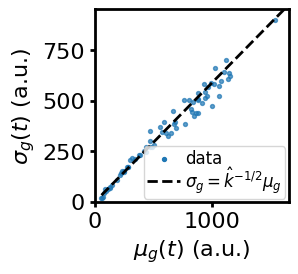

In [41]:
fig, ax = plt.subplots(1, figsize=(2.5,2.5), dpi = 100)
ax.scatter(means_data[:-13], stdevs_data[:-13], alpha=0.7, color='C0', marker='o', s=8)

ax.scatter([100000], [100000], alpha=1, color='C0', marker='o', label='data', s=8)

x_fit = np.linspace(min(means_data), max(means_data), 500)
y_fit = x_fit/np.sqrt(khat) 
ax.plot(x_fit, y_fit, color='black', linestyle='--', lw=2, label=r'$\sigma_g = \hat{k}^{-1/2}\mu_g$')

ax.set_ylim(0,950)
ax.set_xlim(0,1650)

for spine in ax.spines.values():
    spine.set_linewidth(2)

ax.tick_params(labelsize=16, width=2)
ax.set_xlabel(r'$\mu_g(t)$ (a.u.)', fontsize=16)
ax.set_ylabel(r'$\sigma_g(t)$ (a.u.)', fontsize=16)
ax.legend(fontsize=12, loc='lower right', handletextpad=0.3, borderaxespad=0.2, borderpad=0.2, labelspacing=-0.2)
plt.show()

# fig.savefig('figures/Fig1C.pdf', bbox_inches='tight')



## Fig1D

Collapsed data follows a gamma distribution of unit variance: 

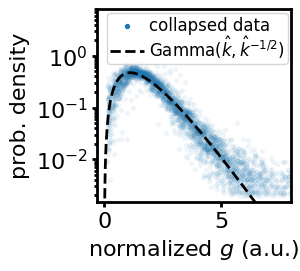

In [43]:
fig, ax = plt.subplots(1, figsize=(2.5,2.5), dpi=100)

for i in range(1, len(g_data)):
    hist_values, bin_edges = np.histogram((g_data[i])/np.std(g_data[i]), bins='auto', density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    ax.scatter(bin_centers, hist_values, color='C0',alpha=0.05, marker='o', s=8)

ax.scatter([100], [100], color='C0',alpha=1, label='collapsed data', s=8)

x_axis = np.linspace(-3, 8, 500)  
shifted_gamma = gamma2.pdf(x_axis, a=khat, scale=1/np.sqrt(khat))
ax.plot(x_axis, shifted_gamma, color='k',linestyle='--', linewidth=2, label=r'$\text{Gamma}(\hat{k}, \hat{k}^{-1/2})$')

ax.set_xlim(-0.3,8)
ax.set_ylim(1.5e-3,8)
ax.set_yscale('log')
ax.set_xlabel(r'normalized $g$ (a.u.)', fontsize=16)
ax.set_ylabel(r'prob. density', fontsize=16)
ax.legend()

for spine in ax.spines.values():
    spine.set_linewidth(2)

ax.tick_params(labelsize=16, width=2, which='both')
ax.legend(fontsize=12, loc='upper right', handletextpad=0.3, borderaxespad=0.2, borderpad=0.2, labelspacing=0)

plt.show()

# fig.savefig('figures/Fig1D.pdf', bbox_inches='tight')

## Fig1E

Mean TopFlash expression vs Wnt "on" duration:

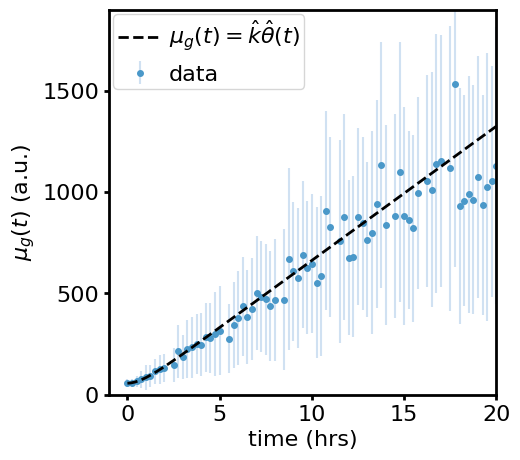

In [169]:
cmap = plt.get_cmap('Blues')
errorcolor = cmap(0.2)
xcolor = cmap(0.6)

fig, ax = plt.subplots(1, figsize=(5,5), dpi=100)

ax.errorbar(t_data, means_data, yerr=stdevs_data, fmt='o', markersize=4, ecolor=errorcolor, color=xcolor, label='data', lw=1.5)
ax.plot(tvec, means, color="k", lw=2, linestyle='--', label=r"$\mu_{g}(t) = \hat{k} \hat{\theta}(t)$",zorder=10)

ax.set_xlim(-1,20)
ax.set_xticks([0, 5, 10, 15, 20])
ax.set_yticks([0, 500, 1000, 1500])
ax.set_xlabel(r'time (hrs)', fontsize=16)
ax.set_ylabel(r'$\mu_{g}(t)$ (a.u.)', fontsize=16)
ax.legend(fontsize=16, handletextpad=0.3, borderaxespad=0.2, borderpad=0.2)

for spine in ax.spines.values():
    spine.set_linewidth(2)

ax.tick_params(labelsize=16, width=2, which='both')
ax.set_ylim(0,1900)
plt.show()

# fig.savefig('figures/Fig1E.pdf', bbox_inches='tight')

# Fig2

## Fig2B

In [171]:
def I_uniform(n):
    # compute mutual information I(g;t) assuming uniform p(t) and n independent measurements
    
    gvec = np.linspace(0, 8000, 1000).reshape(-1, 1)
    tvec = np.linspace(0, tmax, 500).reshape(-1, 1)
    
    dg = (gvec[1] - gvec[0])[0]
    dt = (tvec[1] - tvec[0])[0]

    T, G = np.meshgrid(theta(tvec), gvec)
    p_g_given_t = gamma2.pdf(G, a=n*khat, scale=T/n)

    p_t_uniform = np.ones_like(tvec)
    p_t_uniform /= np.sum(p_t_uniform*dt)
    p_t_uniform = p_t_uniform.reshape(-1,1)

    p_g_uniform = np.matmul(p_g_given_t, p_t_uniform)*dt
    p_g_uniform = p_g_uniform.reshape(-1,1)

    f_kl_uniform = np.sum(p_g_given_t*np.log((p_g_given_t+1e-10)/(p_g_uniform+1e-10)), axis=0)*dg
    f_kl_uniform = f_kl_uniform.reshape(-1,1)

    I = np.sum(p_t_uniform*f_kl_uniform)*dt

    return I

In [172]:
def decoding_map_flat(n):
    # decoding map p(t|tstar) for n independent measurements and a uniform prior p(t)
    
    tvec_long = np.linspace(0, 50, 500)
    tvec_long = tvec_long[1:]

    dt = (tvec_long[1] - tvec_long[0])

    T, G = np.meshgrid(ahat*tvec_long, gvec)
    p_g_given_t = gamma2.pdf(G, a=n*khat, scale=T/n)
    p_t = np.ones_like(tvec_long) / (len(tvec_long)*dt)

    p_g = np.sum(p_g_given_t*p_t[None,:],axis = 1)*dt

    p_t_given_g = p_g_given_t.T * p_t[:,None] / (p_g[None,:] + 1e-20)

    map = np.sum((p_t_given_g.T)[:,:,None]*p_g_given_t[:,None,:]*dg,axis=0)

    return map

Decoding map $p(t \vert t^{*})$ for a uniform prior $p(t)$ and a single measurement of $g$: 

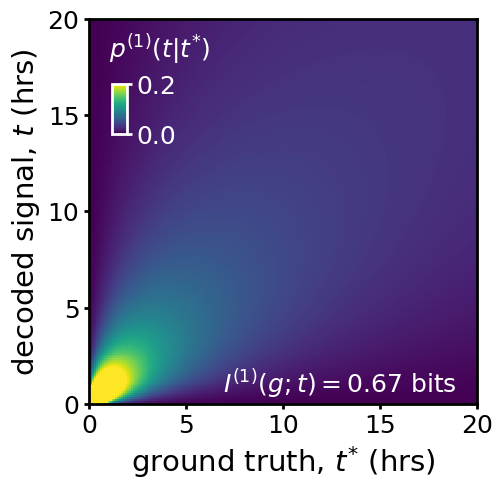

In [48]:
n=1

map = decoding_map_flat(n)
x = np.linspace(0, 50 * 23.03/n, map.shape[1])
y = np.linspace(0, 50 * 23.03/n, map.shape[0])
X, Y = np.meshgrid(x, y)

fig, ax = plt.subplots(figsize=(5, 5))

im = ax.pcolormesh(X, Y, map/n, cmap='viridis', vmin=0, vmax=1)

ax.tick_params(labelsize=18, width=2)

ax.set_ylim(np.array([0,20])*23.03/n)
ax.set_xlim(np.array([0,20])*23.03/n)

ax.set_xticks(np.array([0,5,10,15,20])*23.03/n)
ax.set_yticks(np.array([0,5,10,15,20])*23.03/n)
ax.set_xticklabels(np.array([0,5,10,15,20]))
ax.set_yticklabels(np.array([0,5,10,15,20]))

ax.set_xlabel(r'ground truth, $t^{*}$ (hrs)', fontsize=21) #labelpad=21
ax.set_ylabel(r'decoded signal, $t$ (hrs)', fontsize=21)

cb = fig.add_axes([0.17, 0.65, 0.03, 0.10])
color_bar = plt.colorbar(im, cax = cb, orientation = 'vertical', ticks = [0, 0.2], ticklocation='right')
color_bar.ax.tick_params(axis='y', colors='white', labelsize=18, width=2)
color_bar.outline.set_linewidth(2)
color_bar.outline.set_edgecolor('white')
im.set_clim(0, 0.2)

ax.annotate(r'$p^{(' + str(n) + r')}(t \vert t^{*})$', xy=(0.05, 0.9), xycoords='axes fraction', ha='left', fontsize=18, color='white')
ax.annotate(r'$I^{(' + str(n) + r')}(g;t) = $' + str(np.round(I_uniform(n)/np.log(2),2)) + r' bits', xy=(0.95, 0.03), xycoords='axes fraction', ha='right', fontsize=18, color='white')

for spine in ax.spines.values():
    spine.set_linewidth(2)

ax.set_rasterized(True)

# fig.savefig('./figures/Fig2B.pdf', bbox_inches='tight')

# Fig3

## Fig3A

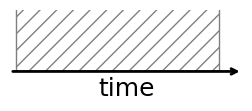

In [50]:
fig, ax = plt.subplots(figsize = (3,0.8), dpi = 100)
colors = [cmap(0.4), cmap(0.55), cmap(0.7), cmap(0.85)]

ax.fill_between([0.05, 1.8], 0, 1, hatch='//', edgecolor='gray', facecolor='none')
ax.annotate('', xy=(0, 0.2), xytext=(2, 0.2), arrowprops=dict(arrowstyle='<-', linewidth=2))

ax.set_xlim(0,2)
ax.set_ylim(0.2, 0.8)
ax.set_yticks([])
ax.set_xticks([])
ax.set_xticklabels([], fontsize=18)
ax.tick_params(labelsize=14)
ax.set_xlabel('time', fontsize=18)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.show()


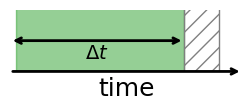

In [51]:
fig, ax = plt.subplots(figsize = (3,0.8), dpi = 100)
colors = [cmap(0.4), cmap(0.55), cmap(0.7), cmap(0.85)]

ax.fill_between([0.05, 1.5], 0, 1, color = 'tab:green', alpha = 0.5)
ax.annotate(r'$\Delta t$', xy=(0.75, 0.32), fontsize=14, color = 'black', ha='center')
ax.annotate('', xy=(0, 0.5), xytext=(1.5, 0.5), arrowprops=dict(arrowstyle='<->', linewidth=2))
ax.fill_between([1.5, 1.8], 0, 1, hatch='//', edgecolor='gray', facecolor='none')

ax.annotate('', xy=(0, 0.2), xytext=(2, 0.2), arrowprops=dict(arrowstyle='<-', linewidth=2))

ax.set_xlim(0,2)
ax.set_ylim(0.2, 0.8)
ax.set_yticks([])
ax.set_xticks([])
ax.set_xticklabels([], fontsize=18)
ax.tick_params(labelsize=14)
ax.set_xlabel('time', fontsize=18)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.show()


## Fig3B

Binning the TopFlash data:

In [174]:
gbins = np.linspace(0, 6000, num=100) 
binned_data_p_g_given_t = [np.histogram(data, bins=gbins)[0] for data in g_data]
binned_data_p_g_given_t = np.array(binned_data_p_g_given_t).T
binned_data_p_g_given_t = binned_data_p_g_given_t / binned_data_p_g_given_t.sum(axis=0, keepdims=True)

In [ ]:
def binned_data_I_binary(index, subsample=False):
    '''
    Mutual information I(g;t) for a binary input t = {0, t_data[index]} using the binned data distribution p(g|t) and the Blahut-Arimoto algorithm. 
    If subsample=True, then we compute p(g|t) by bootstrapping the data (sampling with replacement) instead of using the full dataset.
    '''
    it = 100

    if subsample:
        sampled_data0 = np.random.choice(g_data[0], size=len(g_data[0]), replace=True)
        sampled_data1 = np.random.choice(g_data[index], size=len(g_data[index]), replace=True)
        binary_p_g_given_t = [np.histogram(sampled_data0, bins=gbins)[0], np.histogram(sampled_data1, bins=gbins)[0]]
        binary_p_g_given_t = np.array(binary_p_g_given_t).T
        binary_p_g_given_t = binary_p_g_given_t / binary_p_g_given_t.sum(axis=0, keepdims=True)
    else:
        binary_p_g_given_t = np.array([binned_data_p_g_given_t[:,0], binned_data_p_g_given_t[:,index]]).T

    binary_raw_p_t = np.array([0.5, 0.5])
    binary_raw_p_t = binary_raw_p_t.reshape(-1,1)

    for i in range(it):
        I_L, I_U, f_kl, binary_raw_p_t = blahut_update_disc(binary_raw_p_t, binary_p_g_given_t)
    
    return I_L / np.log(2), I_U / np.log(2), (I_U - I_L) / np.log(2)

def gamma_I_binary(index):
    '''
    Mutual information I(g;t) for a binary input t = {0, tvec[index]} using the gamma fit for p(g|t) and the Blahut-Arimoto algorithm. 
    '''

    binary_prior = np.array([0, tvec[index][0]]).reshape(-1, 1)
    Tbinary, Gbinary = np.meshgrid(theta(binary_prior), gvec)

    p_g_given_t_binary = gamma2.pdf(Gbinary, a=khat, scale=Tbinary)
    p_g_given_t_binary = p_g_given_t_binary / p_g_given_t_binary.sum(axis=0, keepdims=True)

    weights = np.array([0.5, 0.5])
    weights = weights.reshape(-1,1)

    it = 10
    for i in range(it):
        I_L, I_U, f_kl, weights = blahut_update_disc(weights, p_g_given_t_binary)

    p_g = np.matmul(p_g_given_t_binary, weights)
    f_kl_binary = np.sum(p_g_given_t_binary*np.log((p_g_given_t_binary+1e-20)/(p_g+1e-20)), axis=0).reshape(-1, 1)
    I_L = np.sum(f_kl_binary*weights)

    return I_L / np.log(2)

In [177]:
no_subsamples = 50
data_I_binary_vec = np.zeros((no_subsamples, len(t_data)))
gamma_I_binary_vec = np.zeros_like(tvec)
print("... data")
for i in np.arange(len(t_data)):
    for j in np.arange(no_subsamples):
        data_I_binary_vec[j,i] = binned_data_I_binary(i, subsample=True)[0]
print("... gamma")
for i in np.arange(len(tvec)):
    gamma_I_binary_vec[i] = gamma_I_binary(i)

... data
... gamma


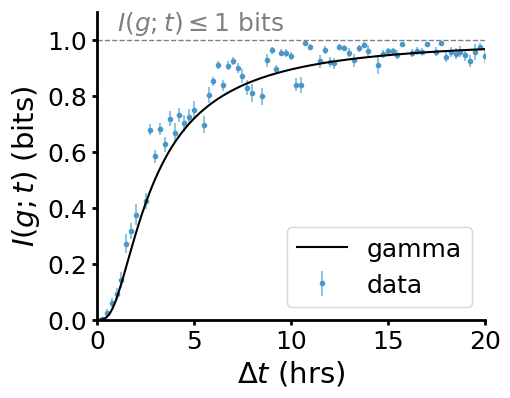

In [178]:
fig, ax = plt.subplots(figsize=(5, 4), dpi=100)
cmap = plt.get_cmap('Blues')
errorcolor = cmap(0.4)
xcolor = cmap(0.6)

ax.plot(tvec, gamma_I_binary_vec, color='k', linewidth=1.5, label='gamma', zorder=10,linestyle='-')
ax.errorbar(t_data, np.mean(data_I_binary_vec, axis=0), yerr=2*np.std(data_I_binary_vec, axis=0), fmt='o', capsize=0,markersize=3,color=xcolor, ecolor=errorcolor, label='data', lw=1.5)
ax.tick_params(labelsize=18, width=2)
ax.set_xlabel(r'$\Delta t$ (hrs)', fontsize=21)
ax.set_ylabel(r'$I(g;t)$ (bits)', fontsize=21)
ax.axhline(y=1, color='gray', linestyle='--', linewidth=1)
ax.legend(fontsize=18, loc = 'best')
ax.set_ylim(0, 1.1)
ax.set_xlim(0, 20)

for spine in ax.spines.values():
    spine.set_linewidth(2)

ax.annotate(r'$I(g;t) \leq 1 \text{ bits}$', xy=(0, 0), xytext=(0.05, 0.94), xycoords='axes fraction', ha='left', fontsize=18, color='gray')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# fig.savefig('./figures/Fig3B.pdf', bbox_inches='tight')

# Fig4

Importing the optimal priors: 

In [59]:
with open('optimal_priors.pkl', 'rb') as f:
    optimized_priors = pickle.load(f) 

In [179]:
n_vec = []
IL_vec = []
IU_vec = []
tpeaks_vec = []
weights_vec = []
for prior in optimized_priors:
    n_vec.append(prior[0])
    IL_vec.append(prior[1])
    IU_vec.append(prior[2])
    tpeaks_vec.append(prior[3])
    weights_vec.append(prior[4])

## Fig4A

Want to see how the continuous Blahut-Arimoto algorithm converges to peaks. 

In [181]:
p_t = np.ones_like(tvec) / (len(tvec)*dt)
count = 0

In [182]:
it = 10001

for i in range(it):
    # convergence Fig
    if count == 10:
        p_t10 = p_t.copy()
    if count == 100:
        p_t100 = p_t.copy()
    if count == 10000:
        p_t10000 = p_t.copy()
    count += 1

    I_L, I_U, f_kl, p_t = blahut_update(tvec, gvec, p_t, p_g_given_t, discrete_x=False)

print(I_L / np.log(2), I_U / np.log(2), (I_U - I_L) / np.log(2))

1.1240129970833657 1.1240721878679052 5.919078453953938e-05


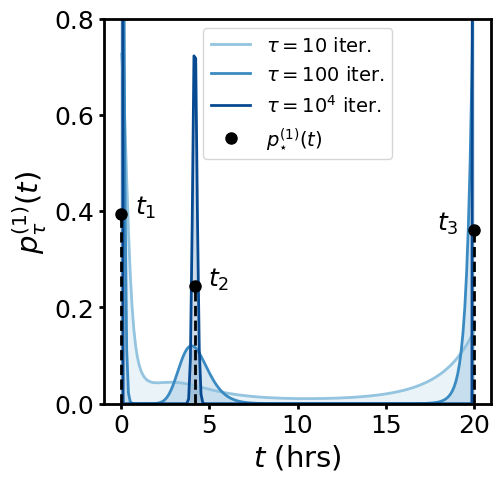

In [183]:
id = 5 # index for N=1

cmap = plt.get_cmap('Blues')
colors = [cmap(0.4), cmap(0.65), cmap(0.9)]

tpeaks = tpeaks_vec[id]
weights = weights_vec[id]

fig, ax1 = plt.subplots(figsize=(5, 5), dpi=100)

ax1.plot(tvec, p_t10, label=r'$\tau = 10$ iter.', color = colors[0], linewidth = 2)
ax1.plot(tvec, p_t100, label=r'$\tau = 100$ iter.', color = colors[1], linewidth = 2)
ax1.plot(tvec, p_t10000, label=r'$\tau = 10^4$ iter.', color = colors[2], linewidth = 2)

ax1.fill_between(tvec.flatten(), 0, p_t10.flatten(), alpha=0.2, color = colors[0])
ax1.fill_between(tvec.flatten(), 0, p_t100.flatten(), alpha=0.2, color = colors[1])
ax1.fill_between(tvec.flatten(), 0, p_t10000.flatten(), alpha=0.2, color = colors[2])

ax1.vlines(tpeaks_vec[id], 0, weights, colors='k', linestyles='dashed', linewidth=2)
ax1.plot(tpeaks_vec[id], weights, marker='o', label=r'$p_{\star}^{(1)}(t)$', markersize=8, linewidth=0, color = 'k')

ax1.set_ylim(0, 0.8)

ax1.set_ylabel(r'$p^{(1)}_{\tau}(t)$', fontsize = 21)
ax1.set_xlabel(r'$t$ (hrs)', fontsize = 21)

ax1.tick_params(labelsize=18, width=2)
ax1.set_xticks([0, 5,10,15,20])

for spine in ax1.spines.values():
    spine.set_linewidth(2)

ax1.legend(fontsize=14, loc = 'upper center')

ax1.annotate(r'$t_1$', xy=(0.08, weights[0]/0.8), xycoords='axes fraction', fontsize=18, ha='left')
ax1.annotate(r'$t_2$', xy=(0.27, weights[1]/0.8), xycoords='axes fraction', fontsize=18, ha='left')
ax1.annotate(r'$t_3$', xy=(0.86, weights[2]/0.8), xycoords='axes fraction', fontsize=18, ha='left')

# fig.savefig('figures/Fig4A.pdf', bbox_inches='tight')

plt.show()

## Fig4B

In [184]:
def I_small_noise(n):
    '''
    Mutual information I(g;t) for n independent measurements, using the gamma fit for p(g|t) and a small-noise approximation for p(t).
    '''
    gvec = np.linspace(0, 8000, 1000).reshape(-1, 1)
    tvec = np.linspace(0, tmax, 500).reshape(-1, 1)
    
    dg = (gvec[1] - gvec[0])[0]
    dt = (tvec[1] - tvec[0])[0]

    T, G = np.meshgrid(theta(tvec), gvec)
    p_g_given_t = gamma2.pdf(G, a=khat*n, scale=T/n)

    p_t_small_noise = (1/(theta(tvec)))*(1-eps(tvec) / tau)
    p_t_small_noise /= np.sum(p_t_small_noise*dt)
    p_t_small_noise = p_t_small_noise.reshape(-1,1)

    p_g_small_noise = np.matmul(p_g_given_t, p_t_small_noise)*dt
    p_g_small_noise = p_g_small_noise.reshape(-1,1)

    f_kl_small_noise = np.sum(p_g_given_t*np.log((p_g_given_t+1e-10)/(p_g_small_noise+1e-10)), axis=0)*dg
    f_kl_small_noise = f_kl_small_noise.reshape(-1,1)

    I = np.sum(p_t_small_noise*f_kl_small_noise)*dt

    return p_t_small_noise, I

def I_large_noise(n):
    '''
    Mutual information I(g;t) for n independent measurements, using the gamma fit for p(g|t) and a large-noise approximation for p(t) (binary prior).
    '''
    gvec = np.linspace(0, 8000, 1000).reshape(-1, 1)
    tvec = np.linspace(0, tmax, 500).reshape(-1, 1)
    
    dg = (gvec[1] - gvec[0])[0]
    dt = (tvec[1] - tvec[0])[0]

    tpeaks = np.array([tvec[0], tvec[-1]]).reshape(-1,1)
    weights = np.ones_like(tpeaks)/len(tpeaks)

    T, G = np.meshgrid(theta(tpeaks), gvec)
    p_g_given_t = gamma2.pdf(G, a=khat*n, scale=T/n)

    # weight step
    convergence_goal = 1e-3
    max_iter = 1000
    err, weights = weight_step(convergence_goal, max_iter, gvec, tpeaks, weights, p_g_given_t)

    p_g_large_noise = np.matmul(p_g_given_t, weights)
    p_g_large_noise = p_g_large_noise.reshape(-1,1)

    f_kl_large_noise = np.sum(p_g_given_t*np.log((p_g_given_t+1e-10)/(p_g_large_noise+1e-10)), axis=0)*dg
    f_kl_large_noise = f_kl_large_noise.reshape(-1,1)

    I = np.sum(weights*f_kl_large_noise)

    return I

def I_exact(n):
    '''
    Mutual information I(g;t) for n independent measurements, using the gamma fit for p(g|t) and the Blahut-Arimoto algorithm to find the optimal p(t).
    '''
    gvec = np.linspace(0, 8000, 1000).reshape(-1, 1)
    tvec = np.linspace(0, tmax, 500).reshape(-1, 1)

    dg = (gvec[1] - gvec[0])[0]
    dt = (tvec[1] - tvec[0])[0]

    T, G = np.meshgrid(theta(tvec), gvec)
    p_g_given_t = gamma2.pdf(G, a=khat*n, scale=T/n)

    p_t = np.ones_like(tvec) / (len(tvec)*dt)

    goal = 1e-3
    while True:
        I_L, I_U, f_kl, p_t = blahut_update(tvec, gvec, p_t, p_g_given_t, False)
        if I_U - I_L < goal:
            break

    p_g = np.matmul(p_g_given_t, p_t)*dt
    p_g = p_g.reshape(-1,1)

    f_kl = np.sum(p_g_given_t*np.log((p_g_given_t+1e-10)/(p_g+1e-10)), axis=0)*dg
    f_kl = f_kl.reshape(-1,1)

    I = np.sum(p_t*f_kl)*dt

    return I

In [ ]:
def decoding_map(n):
    '''
    Decoding map p(t|tstar) for n independent measurements and the optimal prior p(t) found by Blahut-Arimoto.
    '''
    
    id = n_vec.index(n)
    weights = weights_vec[id]
    
    T, G = np.meshgrid(theta(tpeaks_vec[id]), gvec)
    p_g_given_t = gamma2.pdf(G, a=n*khat, scale=T/n)
    
    p_g = np.matmul(p_g_given_t, weights)
    p_t_given_g = p_g_given_t * weights.T / (p_g + 1e-10)

    map = np.matmul(p_t_given_g.T, p_g_given_t)*dg

    return tpeaks_vec[id], map

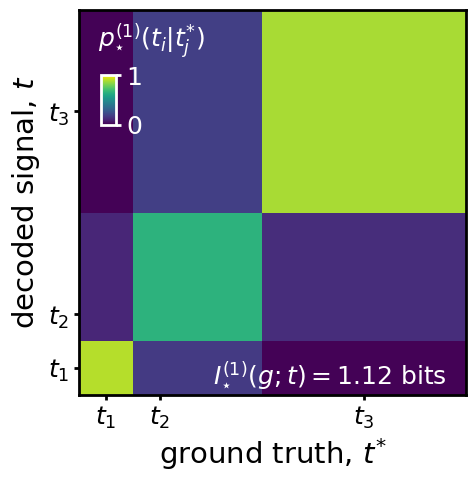

In [186]:
n = 1

tpeaks, map = decoding_map(n)
T, G = np.meshgrid(tpeaks, tpeaks)
labelloc = tpeaks.flatten()

fig, ax = plt.subplots(figsize=(5, 5))
im = ax.pcolormesh(T,G, map, cmap='viridis')

ax.tick_params(labelsize=18, width=2)

ax.set_xticks(labelloc)
ax.set_xticklabels([r'$t_{}$'.format(i+1) for i in range(len(tpeaks))])

ax.set_yticks(labelloc)
ax.set_yticklabels([r'$t_{}$'.format(i+1) for i in range(len(tpeaks))])

ax.set_xlabel(r'ground truth, $t^{*}$', fontsize=21) #labelpad=21
ax.set_ylabel(r'decoded signal, $t$', fontsize=21)

cb = fig.add_axes([0.17, 0.65, 0.03, 0.10])
color_bar = plt.colorbar(im, cax = cb, orientation = 'vertical', ticks = [0, 1], ticklocation='right')
color_bar.ax.tick_params(axis='y', colors='white', labelsize=18, width=2)
color_bar.outline.set_linewidth(2)
color_bar.outline.set_edgecolor('white')
im.set_clim(0, 1)

ax.annotate(r'$p_{\star}^{(' + str(n) + r')}(t_i \vert t_j^{*})$', xy=(0.05, 0.9), xycoords='axes fraction', ha='left', fontsize=18, color='white')
ax.annotate(r'$I^{('+str(n) + r')}_{\star}(g;t) = $' + str(np.round(I_exact(n)/np.log(2),2)) + r' bits', xy=(0.95, 0.03), xycoords='axes fraction', ha='right', fontsize=18, color='white')

for spine in ax.spines.values():
    spine.set_linewidth(2)

ax.set_rasterized(True)
# fig.savefig('./figures/Fig4B.pdf', bbox_inches='tight')


# Fig5

## Fig5A

In [85]:
Nmax = 80
Nmin = 0.4
logNvec = np.linspace(np.log(Nmin)/np.log(2), np.log(Nmax)/np.log(2), 50)

In [86]:
exact_vec = np.array([])
uniform_vec = np.array([])
small_noise_vec = np.array([])
large_noise_vec = np.array([])

for n in 2**logNvec:
    p_x_small_noise, I = I_small_noise(n)
    small_noise_vec = np.append(small_noise_vec, I)

    uniform_vec = np.append(uniform_vec, I_uniform(n))
    large_noise_vec = np.append(large_noise_vec, I_large_noise(n))
    exact_vec = np.append(exact_vec, I_exact(n))

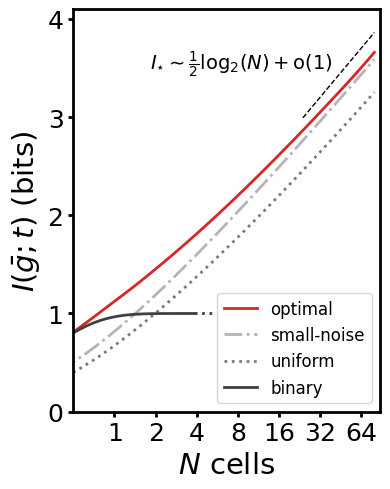

In [ ]:
cmap2 = plt.get_cmap('Grays')
colors2 = [cmap2(0.4), cmap2(0.6), cmap2(0.8)]

fig, ax = plt.subplots(1,figsize=(4, 5), tight_layout=True, dpi=100)

# capacity
ax.plot(2**logNvec, exact_vec/np.log(2), color='tab:red', label = r'optimal', linewidth=2)
# small noise 
ax.plot(2**logNvec, small_noise_vec/np.log(2), color=colors2[0], label=r"small-noise", linestyle='-.', linewidth=2)
# uniform
ax.plot(2**logNvec, uniform_vec/np.log(2), color=colors2[1], label=r'uniform', linestyle='dotted', linewidth=2)
# binary
ax.plot(2**logNvec[:22], large_noise_vec[:22]/np.log(2), color=colors2[2], label=r'binary', linestyle='-', linewidth=2)
ax.plot(2**logNvec[21:25], large_noise_vec[21:25]/np.log(2), color=colors2[2], linestyle='dotted', linewidth=2)

# asymptotic
ax.plot(np.linspace(24, Nmax, 100), 0.5*np.log(np.linspace(24, Nmax, 100)) / np.log(2) + 0.7, color='k', linestyle='--', linewidth=1)
ax.annotate(r'$I_{\star}\sim \frac{1}{2}\mathrm{log}_2(N) + \mathrm{o}(1)$', xy=(0.25,0.85), xycoords='axes fraction', fontsize=14, color='k', ha='left')

ax.set_ylabel(r'$I(\bar{g};t)$ (bits)', fontsize=21)
ax.set_xlabel(r'$N$ cells', fontsize=21)

ax.tick_params(labelsize=18, width=2)
ax.legend(fontsize=12, loc='lower right')

ax.set_xscale('log')

ax.set_ylim(0,4.1)
ax.set_xlim(0.5,Nmax+8)

ax.set_xticks([1,2,4,8,16,32,64])
ax.set_xticklabels([r'$1$', r'$2$', r'$4$', r'$8$', r'$16$', r'$32$', r'$64$'])
ax.minorticks_off()

for spine in ax.spines.values():
    spine.set_linewidth(2)

# fig.savefig('figures/Fig5A.pdf', bbox_inches='tight')
plt.show()

## Fig5B

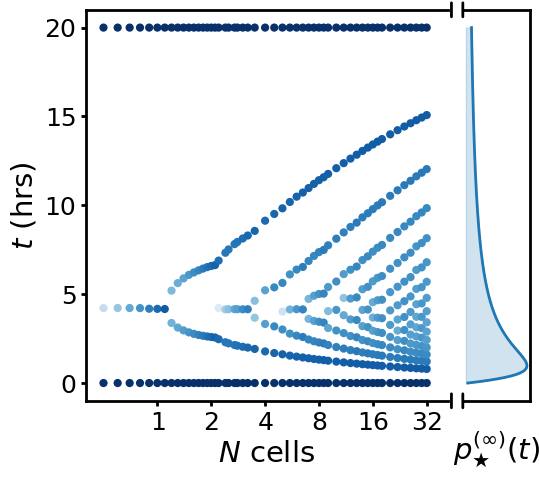

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(5.5, 5), gridspec_kw={'width_ratios': [7, 1.3]}, sharey=True, tight_layout=True)

for i in range(len(n_vec)):
    axs[0].scatter(n_vec[i]*np.ones_like(tpeaks_vec[i]), (tpeaks_vec[i]), c=weights_vec[i].flatten()/np.max(weights_vec[i]), cmap='Blues', s=35, vmin=0, vmax=0.8, edgecolor='k', linewidth=0)

axs[0].tick_params(labelsize=18, width=2)
axs[0].set_yticks([0, 5, 10, 15, 20])
axs[0].set_ylabel(r'$t$ (hrs)', fontsize=21)
axs[0].set_xlabel(r'$N$ cells', fontsize=21)
axs[0].set_xscale('log')
axs[0].set_xticks([1, 2,4,8,16, 32])
axs[0].set_xticklabels([r'$1$', r'$2$', r'$4$', r'$8$', r'$16$', r'$32$'])
axs[0].set_xlim(0.4, 42)
axs[0].minorticks_off()


p_t_small_noise, I = I_small_noise(1)
p_t_small_noise = p_t_small_noise.flatten()  

### Option 1
axs[1].plot(p_t_small_noise / p_t_small_noise.sum(), np.linspace(0, 20, len(p_t_small_noise)), color='tab:blue', linewidth=2)
axs[1].fill_betweenx(np.linspace(0, tmax, len(p_t_small_noise)), 0, p_t_small_noise / p_t_small_noise.sum(), color='tab:blue', alpha=0.2)
axs[1].set_xlabel(r'$p^{(\infty)}_{\bigstar}(t)$', fontsize=21, labelpad=21)
axs[1].set_xticks([])

axs[1].tick_params(axis='y', length=0, width=2)
axs[0].spines['right'].set_visible(False)
axs[1].spines['left'].set_visible(False)

d = .025
axs[0].annotate('', xy=(1.01, 1+d), xytext=(1.01, 1-d), xycoords='axes fraction', textcoords='axes fraction',
                arrowprops=dict(arrowstyle='-', color='black', lw=2))
axs[0].annotate('', xy=(1.01, -d), xytext=(1.01, d), xycoords='axes fraction', textcoords='axes fraction',
                arrowprops=dict(arrowstyle='-', color='black', lw=2))
axs[1].annotate('', xy=(0, -d), xytext=(0, d), xycoords='axes fraction', textcoords='axes fraction',
                arrowprops=dict(arrowstyle='-', color='black', lw=2))
axs[1].annotate('', xy=(0, 1-d), xytext=(0, 1+d), xycoords='axes fraction', textcoords='axes fraction',
               arrowprops=dict(arrowstyle='-', color='black', lw=2))

for spine in axs[0].spines.values():
    spine.set_linewidth(2)
for spine in axs[1].spines.values():
    spine.set_linewidth(2)

# fig.savefig('figures/Fig5B.pdf', bbox_inches='tight')
plt.show()

## Fig5C

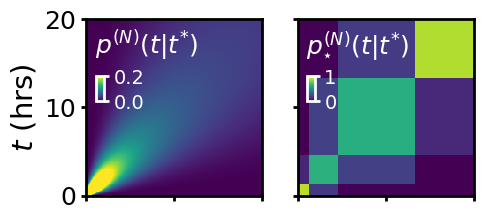

In [ ]:
n = 2

tpeaks, map_disc = decoding_map(n)
Xpos, Ypos = np.meshgrid(tpeaks, tpeaks)

fig = plt.figure(figsize=(5, 2.5), dpi=100)

ax1 = fig.add_subplot(1,2,1, adjustable='box', aspect=1)
ax2 = fig.add_subplot(1,2,2, adjustable='box', aspect=1)

### LEFT PLOT ###

map_flat = decoding_map_flat(n)
x = np.linspace(0, 50, map_flat.shape[1])
y = np.linspace(0, 50, map_flat.shape[0])
X, Y = np.meshgrid(x, y)
im1 = ax1.pcolormesh(X, Y, map_flat, cmap='viridis', vmin=0, vmax=1)

ax1.set_ylim(np.array([0,20]))
ax1.set_xlim(np.array([0,20]))

ax1.set_xticks(np.array([0,10,20]))
ax1.set_yticks(np.array([0,10,20]))

ax1.set_xticklabels([])
ax1.set_yticklabels(np.array([0,10,20]))

ax1.tick_params(labelsize=18, width=2)

ax1.set_ylabel(r'$t$ (hrs)', fontsize=21)

cb = fig.add_axes([0.145, 0.52, 0.015, 0.10])
color_bar = plt.colorbar(im1, cax = cb, orientation = 'vertical', ticks = [0, 0.2], ticklocation='right')
color_bar.ax.tick_params(axis='y', colors='white', labelsize=14, width=2)
color_bar.outline.set_linewidth(2)
color_bar.outline.set_edgecolor('white')
im1.set_clim(0, 0.2)

### RIGHT PLOT ###

im2 = ax2.pcolormesh(Xpos,Ypos, map_disc, cmap='viridis')

ax2.tick_params(labelsize=18, width=2)

ax2.set_xticks(np.array([0,10,20]))

ax2.set_xticklabels([])

ax2.set_yticks(np.array([0,10,20]))
ax2.set_yticklabels([])

ax2.set_xlim(np.array([0,20]))
ax2.set_ylim(np.array([0,20]))

cb2 = fig.add_axes([0.567, 0.52, 0.015, 0.10])
color_bar2 = plt.colorbar(im2, cax = cb2, orientation = 'vertical', ticks = [0, 1], ticklocation='right')
color_bar2.ax.tick_params(axis='y', colors='white', labelsize=14, width=2)
color_bar2.outline.set_linewidth(2)
color_bar2.outline.set_edgecolor('white')
im2.set_clim(0, 1)

ax1.annotate(r'$p^{(N)}(t \vert t^{*})$', xy=(0.05, 0.8), xycoords='axes fraction', ha='left', fontsize=18, color='white')
ax2.annotate(r'$p_{\star}^{(N)}(t \vert t^{*})$', xy=(0.05, 0.8), xycoords='axes fraction', ha='left', fontsize=18, color='white')

im2.set_clim(0, 1)

for spine in ax1.spines.values():
    spine.set_linewidth(2)
for spine in ax2.spines.values():
    spine.set_linewidth(2)

ax1.set_rasterized(True)
ax2.set_rasterized(True)
# plt.savefig('figures/Fig5Ctop.pdf', bbox_inches='tight')

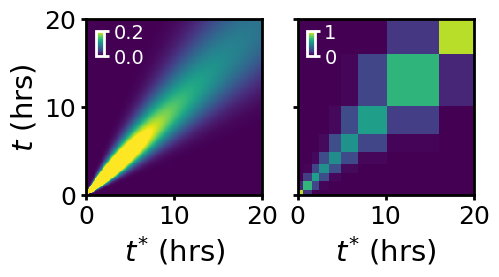

In [ ]:
n = 10

tpeaks, map_disc = decoding_map(n)
Xpos, Ypos = np.meshgrid(tpeaks, tpeaks)

fig = plt.figure(figsize=(5, 2.5), dpi=100)

ax1 = fig.add_subplot(1,2,1, adjustable='box', aspect=1)
ax2 = fig.add_subplot(1,2,2, adjustable='box', aspect=1)

### LEFT PLOT ###

map_flat = decoding_map_flat(n)
x = np.linspace(0, 50, map_flat.shape[1])
y = np.linspace(0, 50, map_flat.shape[0])
X, Y = np.meshgrid(x, y)
im1 = ax1.pcolormesh(X, Y, map_flat, cmap='viridis', vmin=0, vmax=1)

ax1.set_ylim(np.array([0,20]))
ax1.set_xlim(np.array([0,20]))

ax1.set_xticks(np.array([0,10,20]))
ax1.set_yticks(np.array([0,10,20]))

ax1.set_xticklabels(np.array([0,10,20]))
ax1.set_yticklabels(np.array([0,10,20]))

ax1.tick_params(labelsize=18, width=2)

ax1.set_ylabel(r'$t$ (hrs)', fontsize=21)
ax1.set_xlabel(r'$t^{*}$ (hrs)', fontsize=21)


cb = fig.add_axes([0.145, 0.7, 0.015, 0.10])
color_bar = plt.colorbar(im1, cax = cb, orientation = 'vertical', ticks = [0, 0.2], ticklocation='right')
color_bar.ax.tick_params(axis='y', colors='white', labelsize=14, width=2)
color_bar.outline.set_linewidth(2)
color_bar.outline.set_edgecolor('white')
im1.set_clim(0, 0.2)


### RIGHT PLOT ###

im2 = ax2.pcolormesh(Xpos,Ypos, map_disc, cmap='viridis')

ax2.tick_params(labelsize=18, width=2)

ax2.set_xlabel(r'$t^{*}$ (hrs)', fontsize=21)

ax2.set_xticks(np.array([0,10,20]))
ax2.set_xticklabels(np.array([0,10,20]))

ax2.set_yticks(np.array([0,10,20]))
ax2.set_yticklabels([])

ax2.set_xlim(np.array([0,20]))
ax2.set_ylim(np.array([0,20]))

cb2 = fig.add_axes([0.567, 0.7, 0.015, 0.10])
color_bar2 = plt.colorbar(im2, cax = cb2, orientation = 'vertical', ticks = [0, 1], ticklocation='right')
color_bar2.ax.tick_params(axis='y', colors='white', labelsize=14, width=2)
color_bar2.outline.set_linewidth(2)
color_bar2.outline.set_edgecolor('white')
im2.set_clim(0, 1)

for spine in ax1.spines.values():
    spine.set_linewidth(2)
for spine in ax2.spines.values():
    spine.set_linewidth(2)

ax1.set_rasterized(True)
ax2.set_rasterized(True)
# plt.savefig('figures/Fig5Cbottom.pdf', bbox_inches='tight')

# Fig6

## Fig6AB

In [112]:
fine_tuning_fixed_weights = np.load('fine_tuning/fine_tuning_fixed_weights.npy')

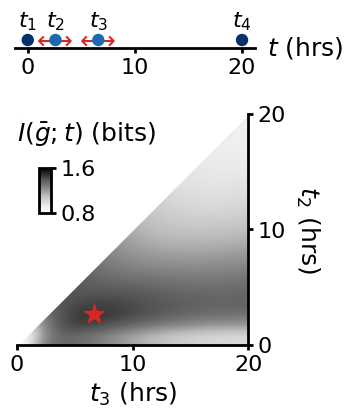

<Figure size 640x480 with 0 Axes>

In [ ]:
fig, ax = plt.subplots(figsize=(3, 3), dpi=100)

cs = ax.imshow((fine_tuning_fixed_weights / np.log(2)), cmap='Grays', extent=[0, 20, 0, 20], origin='lower', zorder=-1)

triangle = np.array([[0, 0], [0, 20], [20, 20]])
ax.fill(triangle[:, 0], triangle[:, 1], color='white', zorder=2)

ax.set_xlabel(r'$t_3$ (hrs)', fontsize=18)
ax.set_ylabel(r'$t_2$ (hrs)', fontsize=18, rotation=270, labelpad=25)
ax.tick_params(labelsize=16, width=2)

cb = fig.add_axes([0.2, 0.55, 0.04, 0.15])
color_bar = plt.colorbar(cs, cax = cb, orientation = 'vertical', ticks = [0.8, 1.6])
color_bar.outline.set_linewidth(2)
color_bar.ax.tick_params(axis='y', colors='black', labelsize=16, width=2)
cs.set_clim(0.8, 1.6)

ax.annotate(r'$I(\bar{g};t)$ (bits)', xy=(0.6, 0.88), xycoords='axes fraction', fontsize=18, ha='right', color='black')

max_index = np.unravel_index(np.argmax(fine_tuning_fixed_weights), fine_tuning_fixed_weights.shape)
max_t2 = np.linspace(0,20,len(fine_tuning_fixed_weights))[max_index[1]]
max_t3 = np.linspace(0,20,len(fine_tuning_fixed_weights))[max_index[0]]

# Mark the position with a red star
ax.plot(max_t2, max_t3, '*', markersize=15, color = 'tab:red')

ax.spines[['top', 'left']].set_visible(False)
for spine in ax.spines.values():
    spine.set_linewidth(2)

ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.set_yticks([0,10,20])

### INSET ###
left, bottom, width, height = [0.12, 1.1, 0.8, 0.1]
ax2 = fig.add_axes([left, bottom, width, height])

id = n_vec.index(2)

# Plot the positions on a number line
plot = ax2.scatter((tpeaks_vec[id]), np.zeros_like(tpeaks_vec[id])+0.25, c=weights_vec[id].flatten()/np.max(weights_vec[id]), cmap='Blues', s=80, vmin=0, vmax=0.8, edgecolor='k', linewidth=0)


ax2.spines[['top', 'right','left']].set_visible(False)
ax2.spines['bottom'].set_zorder(-1)
for spine in ax2.spines.values():
    spine.set_linewidth(2)

ax2.set_ylim(0, 1)
ax2.set_yticks([])

ax2.tick_params(axis='x', labelsize=16, width=2)
ax2.set_xticks([0,10,20])
ax2.set_xlim(-1.2,21.2)

for i, p in enumerate(tpeaks_vec[id]):
    ax2.annotate(r'$t_{}$'.format(i + 1), xy=(p, 0.9), xycoords='data', fontsize=16, ha='center', va='center')
ax2.annotate(r'$t$ (hrs)', fontsize=18, xy=(1.05, 0), xycoords='axes fraction', ha='left', va='center')

ax2.annotate(r'$\longleftrightarrow$', xy=(tpeaks_vec[id][1] - 0.22, 0.25), xycoords='data', fontsize=18, ha='center', va='center', zorder=-10, color='tab:red')
ax2.annotate(r'$\longleftrightarrow$', xy=(tpeaks_vec[id][2] - 0.22, 0.25), xycoords='data', fontsize=18, ha='center', va='center', zorder=-10, color='tab:red')

plt.show()

# plt.savefig('figures/Fig6AB.pdf', bbox_inches='tight')


## Fig6C

In [136]:
def hessian(n):

    tpeaks = tpeaks_vec[n_vec.index(n)]
    weights = weights_vec[n_vec.index(n)]

    tpeaks = tpeaks.flatten() # dimT
    weights = weights.flatten() # dimT

    gvec = np.linspace(0, 8000, 8000) # dimG
    dg = (gvec[1] - gvec[0]) # scalar

    T, G = np.meshgrid(theta(tpeaks), gvec) # dimG x dimT

    p_g_given_t = gamma2.pdf(G, a=n*khat, scale=T/n) # dimG x dimT

    dtheta_dt = ahat*(1-(1/tau)*eps(tpeaks)) # dimT
    d2theta_dt2 = ahat*(1/tau)**2*eps(tpeaks) # dimT

    d_pgt_dt = (-n*khat/T + n*G / T**2) * p_g_given_t * dtheta_dt[None,:] # dimG x dimT
    d2_pgt_dt2 = ((n*khat/T**2 - 2*n*G/T**3) + (-n*khat/T + n*G / T**2)**2) * p_g_given_t * dtheta_dt[None,:]**2 + (-n*khat/T + n*G / T**2) * p_g_given_t * d2theta_dt2[None,:]

    p_g = np.matmul(p_g_given_t, weights) # dimG

    kronecker_delta = np.eye(len(tpeaks)) # dimT x dimT

    # integrand: dimG x dimT x dimT, (g, i ,j)
    integrand = -weights[None,:, None]*weights[None, None, :]*(1/(p_g+1e-20))[:,None,None]*d_pgt_dt[:, :, None]*d_pgt_dt[:, None, :]
    integrand += kronecker_delta[None,:,:]*weights[None,:,None]*(d2_pgt_dt2[:,:,None]*np.log((p_g_given_t[:,:,None]+1e-30)/(p_g[:,None,None]+1e-20)) + (1/(p_g_given_t[:,:,None]+1e-20))*d_pgt_dt[:,:,None]**2)

    H = np.sum(integrand, axis=0)*dg # dimT x dimT
    
    return H / np.log(2)

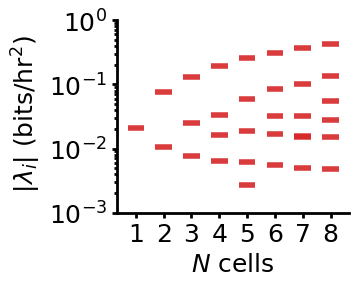

In [141]:
nvec = np.arange(1,9)
lambdas = np.array([])
nvec_long = np.array([])

for n in nvec:
    H = hessian(n)[1:-1,1:-1]
    lambdas = np.append(lambdas, np.linalg.eigvalsh(H))
    nvec_long = np.append(nvec_long, np.full(len(H), n))

x = nvec_long
y = np.abs(lambdas)

fig, ax = plt.subplots(figsize=(3,2.5), dpi=100)

for xi in np.unique(x):
    yi = y[x == xi]
    ax.hlines(yi, xi - 0.3, xi + 0.3, color='tab:red', lw=4, alpha=0.9)

ax.set_xlabel(r'$N$ cells', fontsize=18)
ax.set_ylabel(r' $\vert \lambda_i \vert$ (bits/$\text{hr}^{2}$)', fontsize=18)

ax.set_xticks(nvec)
ax.tick_params(labelsize=18, width=2, which='both')

ax.set_yscale('log')
ax.spines[['top','right']].set_visible(False)

for spine in ax.spines.values():
    spine.set_linewidth(2)

ax.set_yticks([1e-3, 1e-2, 1e-1, 1e0])

plt.show()
# fig.savefig('./figures/Fig6C.pdf', bbox_inches='tight')

# Fig7

In [148]:
from scipy.spatial import cKDTree

In [147]:
spatial_g = np.load('spatial_data/g.npy')
coordinates = np.load('spatial_data/coordinates.npy')

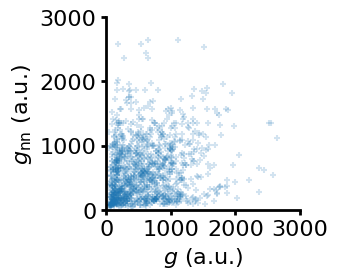

In [161]:
# Create a KDTree for efficient nearest neighbor search
tree = cKDTree(coordinates)

# Find the nearest neighbor for each point (excluding the point itself)
distances, indices = tree.query(coordinates, k=2)
nn_indices = indices[:, 1:]

# Get the meanC1 values of the nearest neighbors
g_nn = np.mean(spatial_g[nn_indices], axis=1)

# Calculate the correlation between meanC1 and the meanC1 of the nearest neighbor

fig, ax = plt.subplots(figsize=(2.5,2.5), dpi = 100)
ax.set_xlabel(r'$g$ (a.u.)', fontsize=16)
ax.set_ylabel(r'$g_\mathrm{nn}$ (a.u.)', fontsize=16)
ax.tick_params(labelsize=16, width=2)
ax.scatter(spatial_g, g_nn, alpha=0.2, marker='+', color='C0', s=20)
ax.set_xlim([0, 3000])
ax.set_ylim([0, 3000])
ax.set_xticks([0, 1000, 2000, 3000])
ax.set_yticks([0, 1000, 2000, 3000])

for spine in ax.spines.values():
    spine.set_linewidth(2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.savefig('figures/Fig7A.pdf', bbox_inches='tight')

In [151]:
g_scrambled = np.random.permutation(spatial_g)

subsample_size = 1/np.array([0.001, 0.0012,0.0014, 0.0016, 0.0018,0.002, 0.0022, 0.0024, 0.0026, 0.0028, 0.003])
bin_size = 100
gmax = 3500
reps = 500

h_g_mean = []
h_g_std = []

h_jointNN_mean = []
h_jointScr_mean = []

h_jointNN_std = []
h_jointScr_std = []

I_nn_mean = []
I_scr_mean = []
I_nn_std = []
I_scr_std = []

for subsample in subsample_size:
    out_h_g = []
    out_h_jointNN = []
    out_h_jointScr = []

    out_I_nn = []
    out_I_scr = []

    for _ in range(reps):
        subsample_indices = np.random.choice(len(spatial_g), size=int(subsample), replace=False)
        g_subsample = spatial_g[subsample_indices]
        g_scrambled_subsample = g_scrambled[subsample_indices]
        g_nn_subsample = g_nn[subsample_indices]

        bin_edges = np.arange(0, gmax + bin_size, bin_size)  # Define bin edges with a specific bin size
        p_g, _ = np.histogram(g_subsample, bins=bin_edges, density=False)
        p_g = p_g / np.sum(p_g)
        mask_g = np.where(p_g > 0)
        h_g = -np.sum((p_g[mask_g])*np.log(p_g[mask_g])) + np.log(bin_size)

        histScr, xedges, yedges = np.histogram2d(g_subsample, g_scrambled_subsample, bins=[bin_edges, bin_edges], density=False)
        histNN, xedges, yedges = np.histogram2d(g_subsample, g_nn_subsample, bins=[bin_edges, bin_edges], density=False)

        jointNN = histNN / np.sum(histNN)
        jointScr = histScr / np.sum(histScr)

        mask_jointNN = np.where(jointNN > 0)
        h_jointNN = -np.sum((histNN[mask_jointNN] / np.sum(histNN[mask_jointNN]))*np.log(histNN[mask_jointNN] / np.sum(histNN[mask_jointNN]))) + 2*np.log(bin_size)

        mask_jointScr = np.where(jointScr > 0)
        h_jointScr = -np.sum((histScr[mask_jointScr] / np.sum(histScr[mask_jointScr]))*np.log(histScr[mask_jointScr] / np.sum(histScr[mask_jointScr]))) + 2*np.log(bin_size)

        out_h_g.append(h_g)
        out_h_jointNN.append(h_jointNN)
        out_h_jointScr.append(h_jointScr)

        out_I_nn.append(h_g + h_g - h_jointNN)
        out_I_scr.append(h_g + h_g - h_jointScr)

    h_g_mean.append(np.mean(out_h_g))
    h_g_std.append(np.std(out_h_g))

    h_jointNN_mean.append(np.mean(out_h_jointNN))
    h_jointNN_std.append(np.std(out_h_jointNN))

    h_jointScr_mean.append(np.mean(out_h_jointScr))
    h_jointScr_std.append(np.std(out_h_jointScr))

    I_nn_mean.append(np.mean(out_I_nn))
    I_scr_mean.append(np.mean(out_I_scr))

    I_nn_std.append(np.std(out_I_nn))
    I_scr_std.append(np.std(out_I_scr))

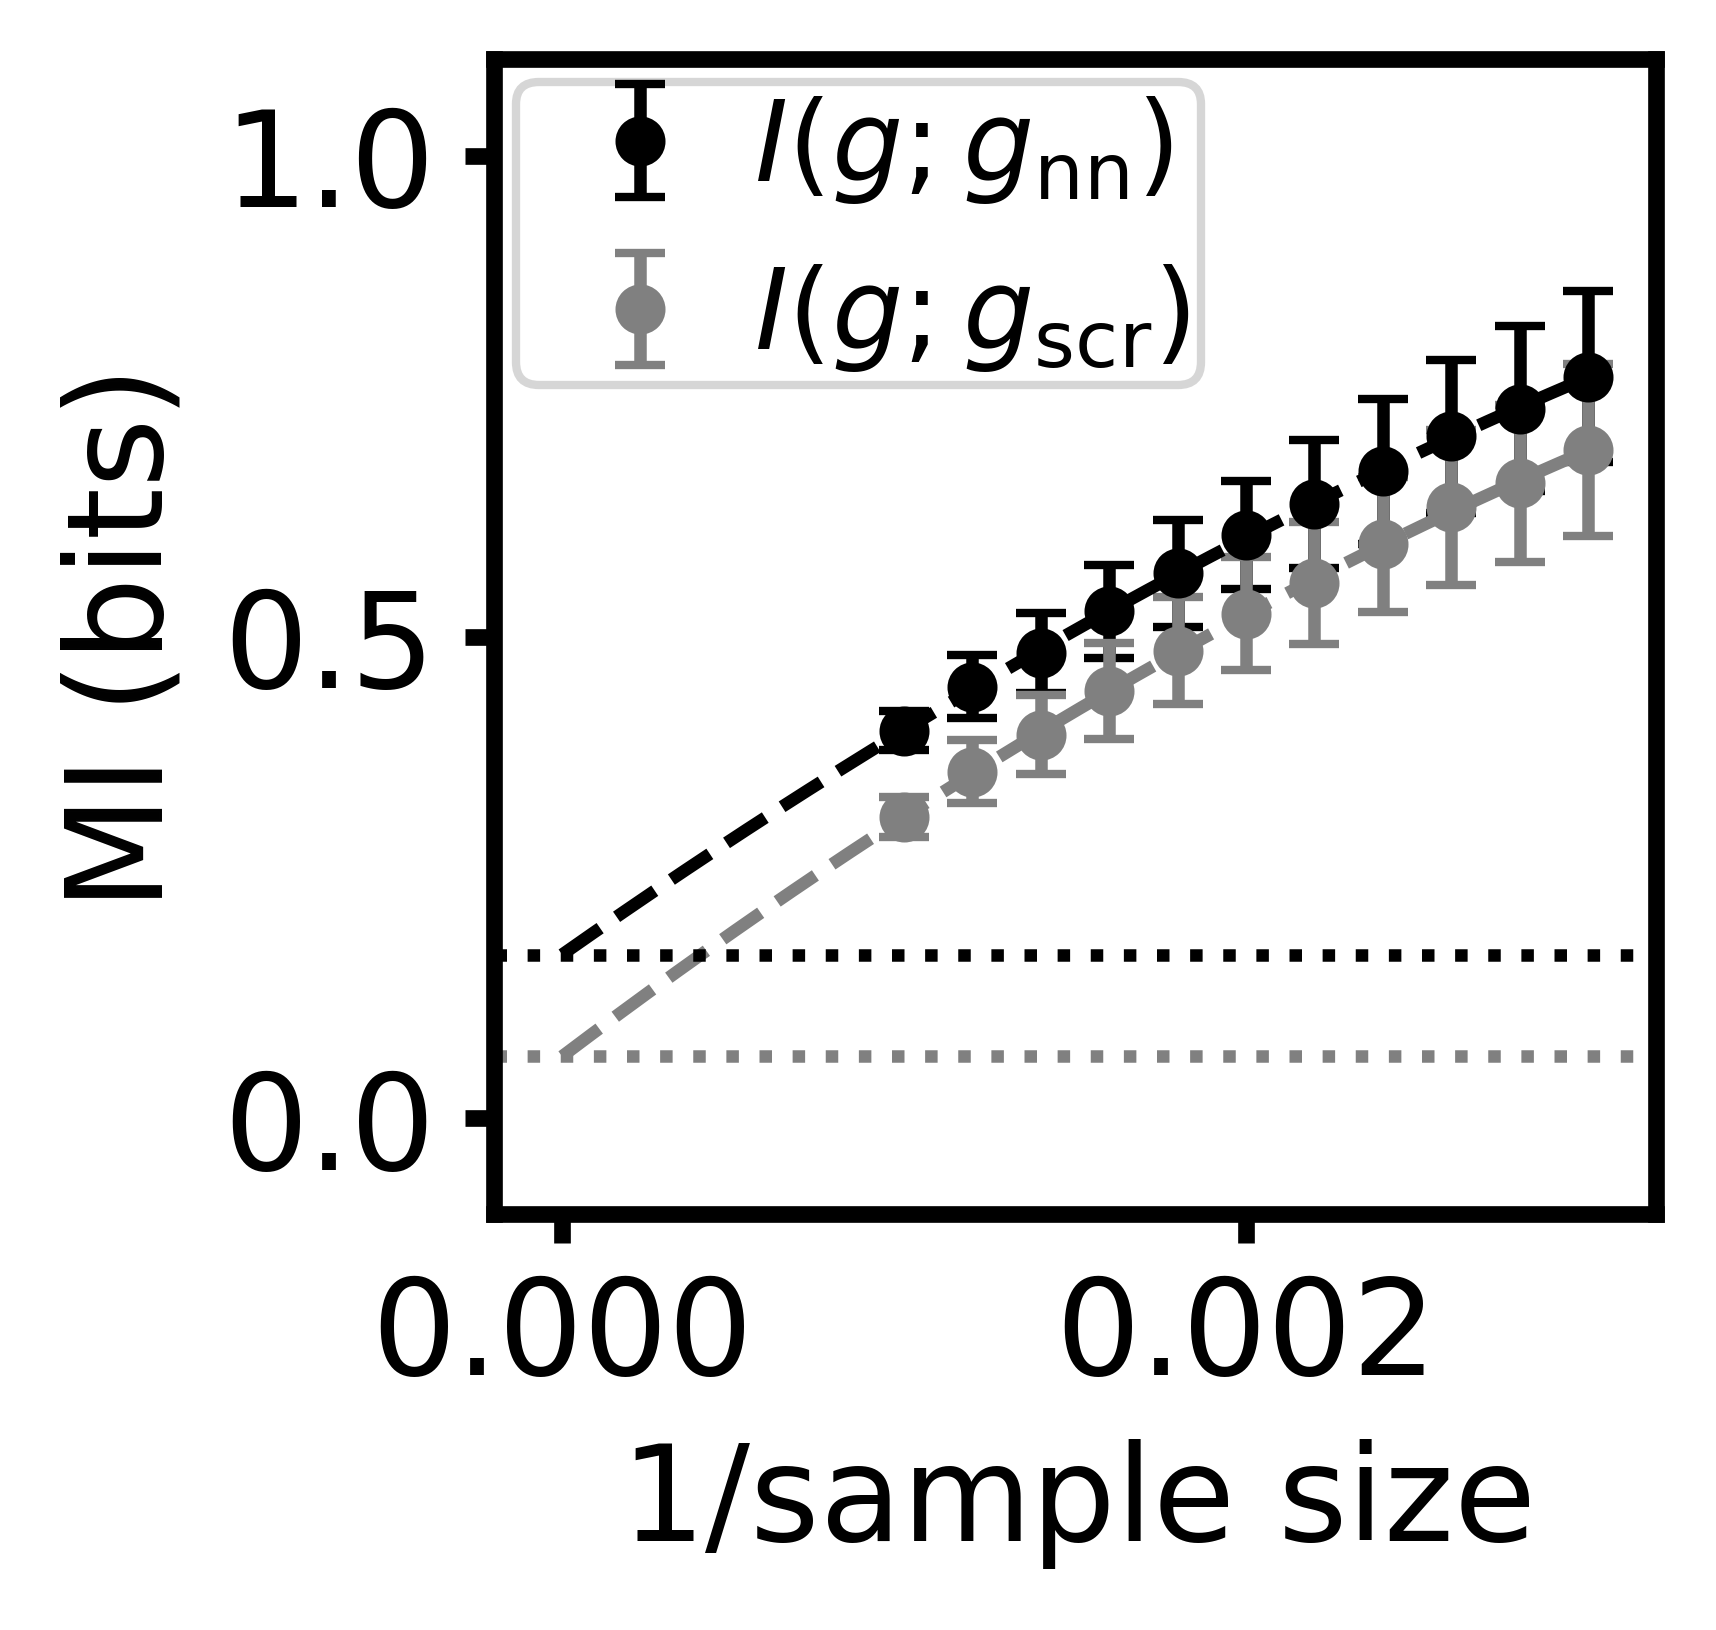

In [ ]:
fig, ax = plt.subplots(figsize=(2.5,2.5), dpi=600)

ax.errorbar(1/subsample_size, I_nn_mean/np.log(2), yerr = I_nn_std/np.log(2), marker='o', linestyle='None', capsize = 3, color='black', markersize=5, label=r'$I(g ; g_{\mathrm{nn}})$')
ax.errorbar(1/subsample_size, I_scr_mean/np.log(2), yerr = I_scr_std/np.log(2), marker='o', linestyle='None', capsize = 3, color='gray', markersize=5, label=r'$I(g ; g_{\mathrm{scr}})$')

coefficients_NN = np.polyfit(1/subsample_size, I_nn_mean, 2)
polynomial_NN = np.poly1d(coefficients_NN)
x_fit_NN = np.linspace(0, max(1/subsample_size), 500)
y_fit_NN = polynomial_NN(x_fit_NN)
ax.plot(x_fit_NN, y_fit_NN/np.log(2), color='black', linestyle='--')

coefficients_Scr = np.polyfit(1/subsample_size, I_scr_mean, 2)
polynomial_Scr = np.poly1d(coefficients_Scr)
x_fit_Scr = np.linspace(0, max(1/subsample_size), 500)
y_fit_Scr = polynomial_Scr(x_fit_Scr)
ax.plot(x_fit_Scr, y_fit_Scr/np.log(2), color='gray', linestyle='--')

ax.axhline(y=y_fit_NN[0]/np.log(2), color='black', linestyle=':', linewidth=1.5)
ax.axhline(y=y_fit_Scr[0]/np.log(2), color='gray', linestyle=':', linewidth=1.5)

ax.set_xlim(-0.0002, 0.0032)

ax.set_ylim(-0.1, 1.1)


ax.tick_params(labelsize=16, width = 2)
ax.set_xlabel(r'$1/$sample size', fontsize=16)
ax.set_ylabel(r'MI (bits)', fontsize=16)

for spine in ax.spines.values():
    spine.set_linewidth(2)


ax.legend(fontsize=13.5, handletextpad=0.01, borderaxespad=0.2, borderpad=0.1)

# plt.savefig('./figures/Fig7B.pdf', bbox_inches='tight')

# Fig8

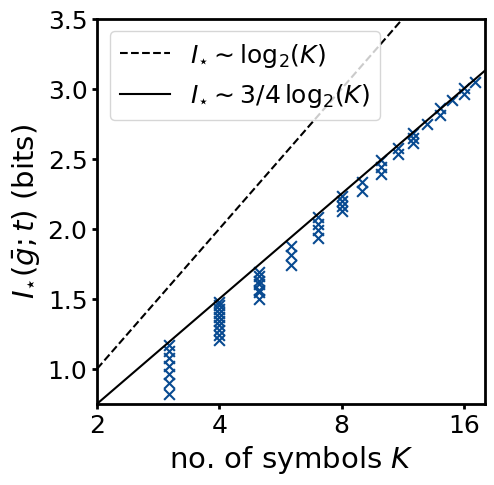

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))

x1 = np.linspace(2,32,100)
y1 = np.log(x1)/np.log(2)
ax.plot(x1, y1, color = 'black', linestyle = '--', label=r'$I_{\star} \sim \mathrm{log}_2(K)$') 

y2 = 0.75*np.log(x1)/np.log(2)
ax.plot(x1, y2, color = 'black', linestyle = '-', label=r'$I_{\star} \sim 3/4 \, \mathrm{log}_2(K)$')

for i in range(len(n_vec)):
    if len(tpeaks_vec[i]) < 100:
        ax.scatter(len(tpeaks_vec[i]), IL_vec[i] / np.log(2), s=60, marker='x', color=colors[-1])

ax.set_xscale('log')
ax.set_xticks([2,4,8,16])
ax.set_xticklabels([2,4,8,16])
ax.minorticks_off()
ax.tick_params(labelsize=18, width=2)
ax.set_xlabel(r'no. of symbols $K$', fontsize=21)
ax.set_ylabel(r'$I_{\star}(\bar{g};t)$ (bits)', fontsize=21)
ax.set_ylim(0.75,3.5)
ax.set_xlim(2,18)

ax.legend(fontsize=18, loc='upper left')

for spine in ax.spines.values():
    spine.set_linewidth(2)

# fig.savefig('figures/Fig8.pdf',bbox_inches='tight')


# Fig9

In [142]:
fine_tuning_variable_weights = np.load('fine_tuning/fine_tuning_variable_weights.npy')

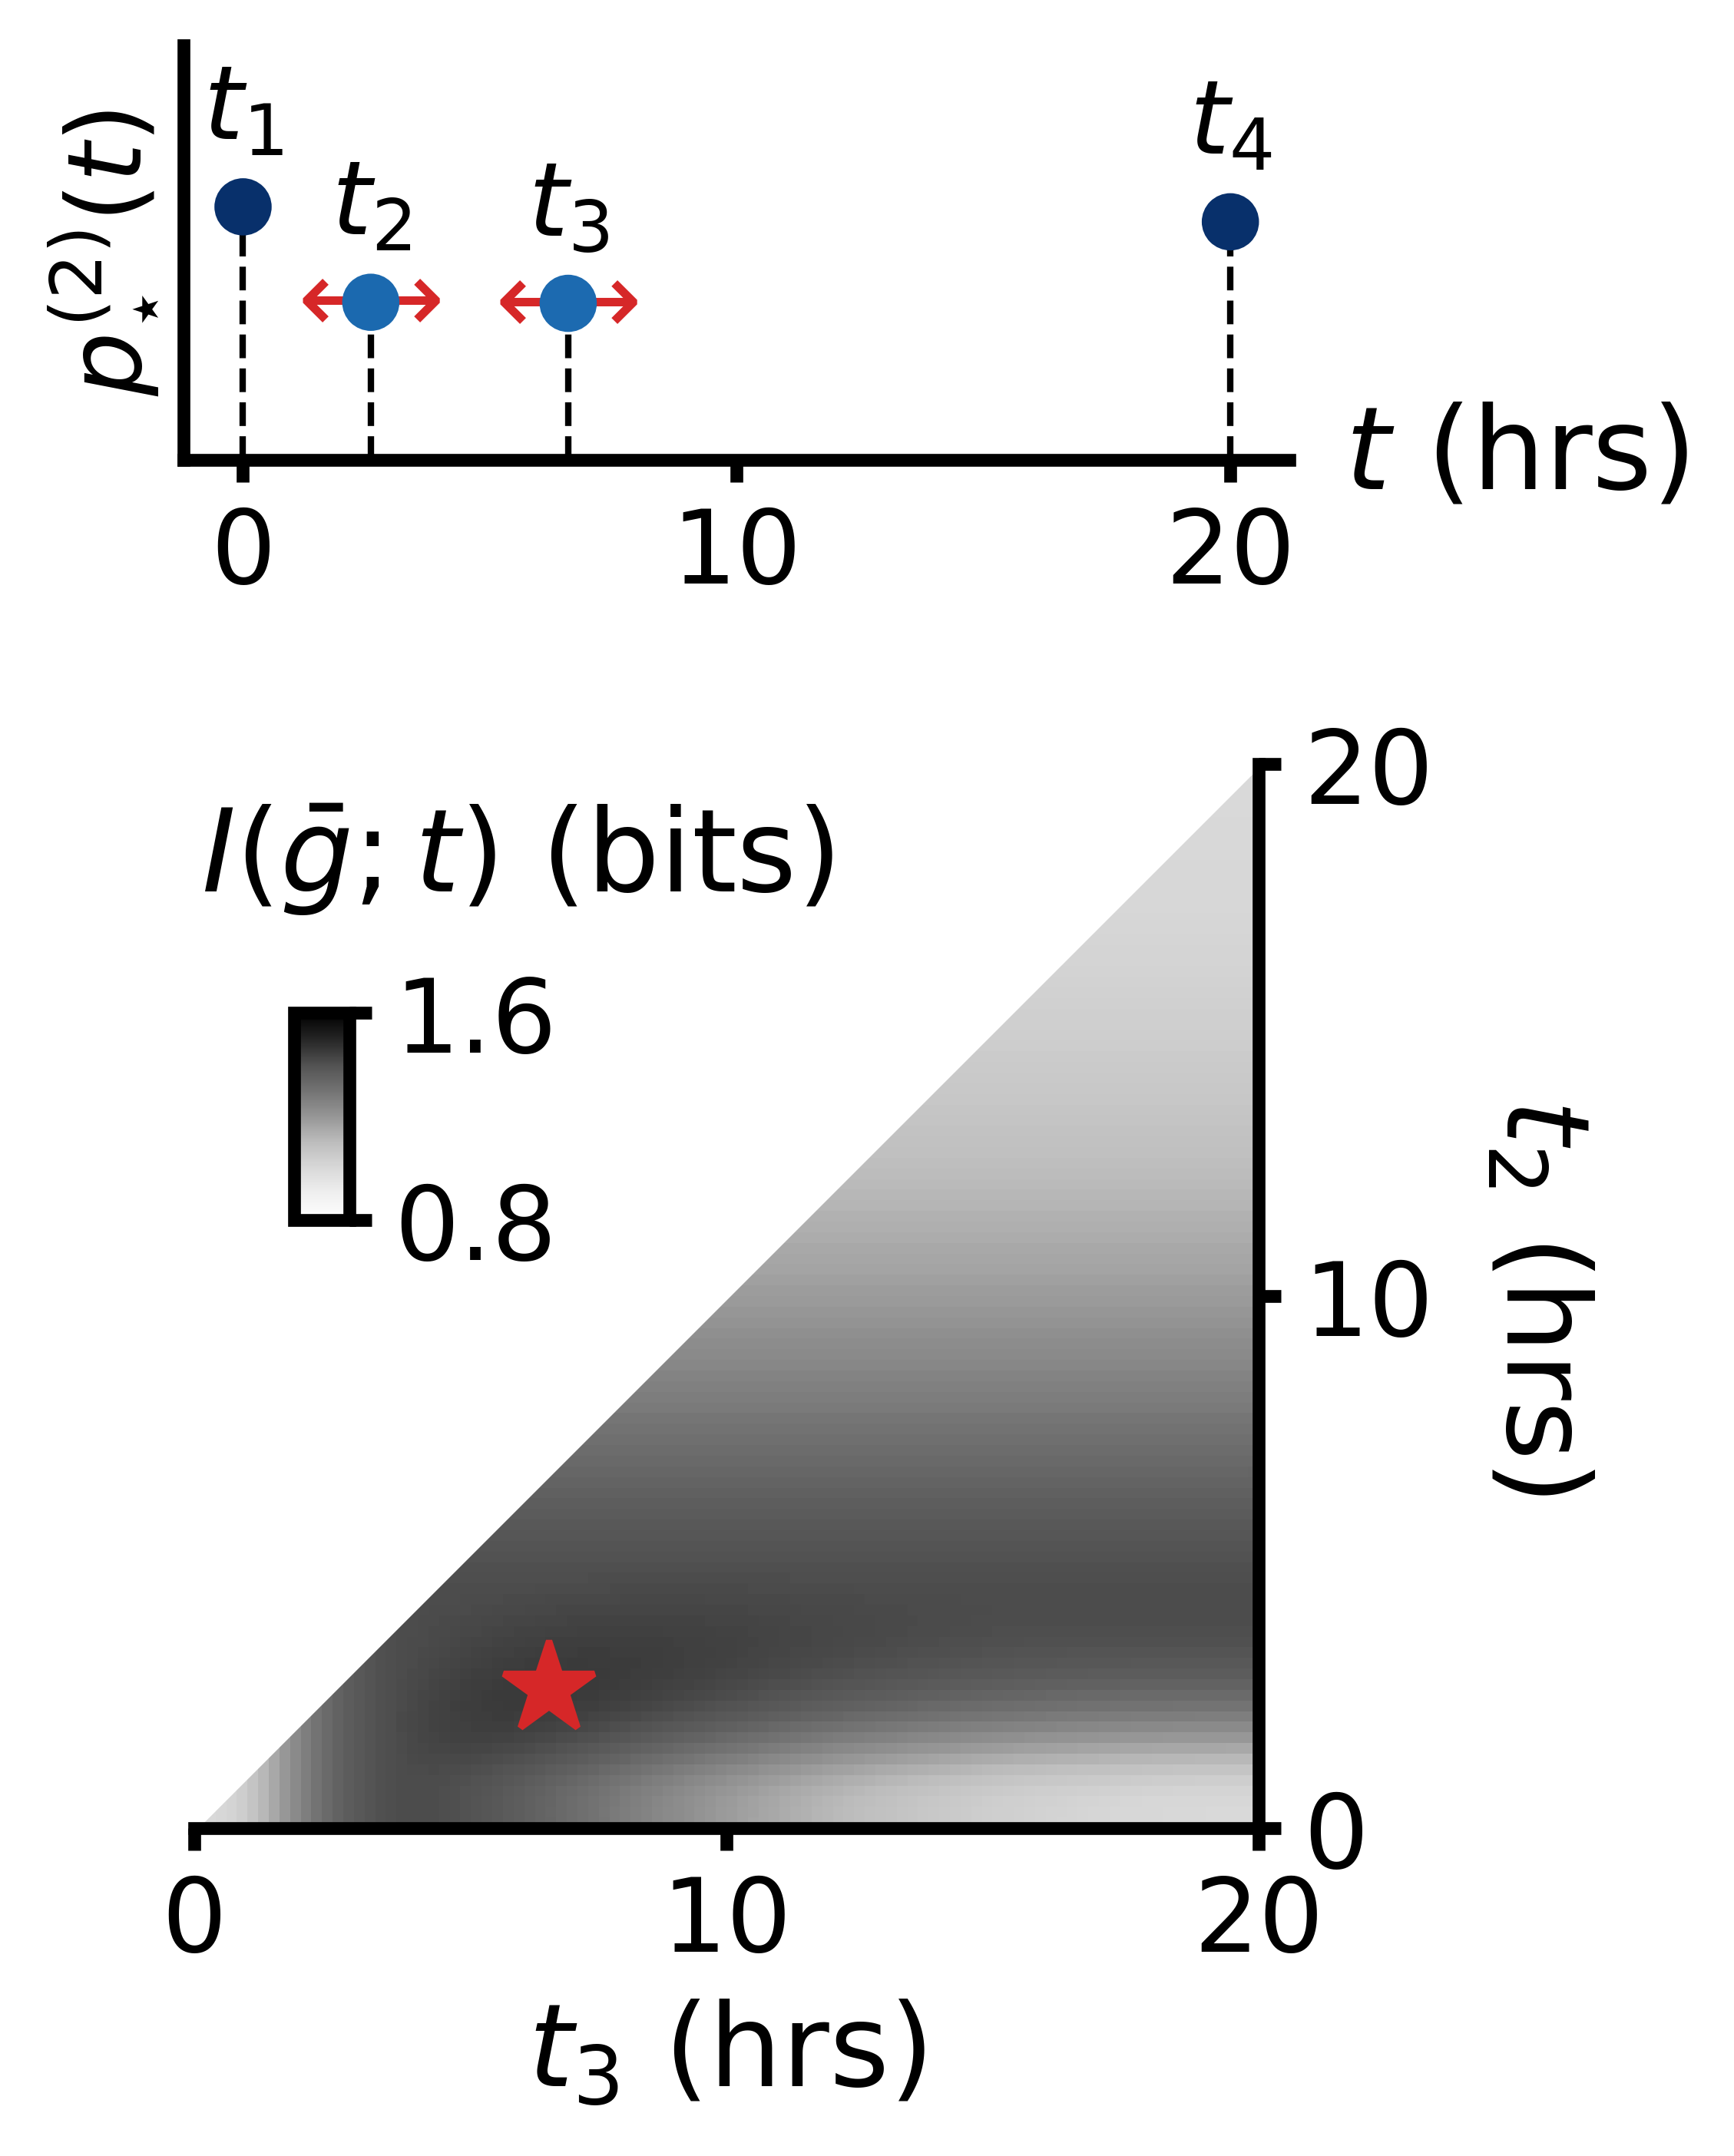

In [ ]:
fig, ax = plt.subplots(figsize=(3, 3), dpi=600)

# Update the plot to make the masked region white
cs = ax.imshow((fine_tuning_variable_weights / np.log(2)), cmap='Grays', extent=[0, 20, 0, 20], origin='lower', zorder=-1)

# Create a white triangle mask
triangle = np.array([[0, 0], [0, 20], [20, 20]])
ax.fill(triangle[:, 0], triangle[:, 1], color='white', zorder=2)

ax.set_xlabel(r'$t_3$ (hrs)', fontsize=18)
ax.set_ylabel(r'$t_2$ (hrs)', fontsize=18, rotation=270, labelpad=25)
ax.tick_params(labelsize=16, width=2)

cb = fig.add_axes([0.2, 0.55, 0.04, 0.15])
color_bar = plt.colorbar(cs, cax = cb, orientation = 'vertical', ticks = [0.8, 1.6])
color_bar.outline.set_linewidth(2)
color_bar.ax.tick_params(axis='y', colors='black', labelsize=16, width=2)
cs.set_clim(0.8, 1.6)

ax.annotate(r'$I(\bar{g};t)$ (bits)', xy=(0.6, 0.88), xycoords='axes fraction', fontsize=18, ha='right', color='black')

# Find the indices of the maximum value in the out array
max_index = np.unravel_index(np.argmax(fine_tuning_variable_weights), fine_tuning_variable_weights.shape)
max_t2 = np.linspace(0,20,len(fine_tuning_variable_weights))[max_index[1]]
max_t3 = np.linspace(0,20,len(fine_tuning_variable_weights))[max_index[0]]

# Mark the position with a red star
ax.plot(max_t2, max_t3, '*', markersize=15, color = 'tab:red')

ax.spines[['top', 'left']].set_visible(False)
for spine in ax.spines.values():
    spine.set_linewidth(2)

ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.set_yticks([0,10,20])

### INSET ###
left, bottom, width, height = [0.12, 1.1, 0.8, 0.3]
ax2 = fig.add_axes([left, bottom, width, height])

id = n_vec.index(2)
tpeaks = tpeaks_vec[id]
weights = weights_vec[id].flatten()

ax2.vlines(tpeaks, 0, weights, colors='k', linestyles='dashed', linewidth=1, zorder=-10)
plot = ax2.scatter((tpeaks), weights, c=weights.flatten()/np.max(weights), cmap='Blues', s=80, vmin=0, vmax=0.8, edgecolor='k', linewidth=0)

ax2.spines[['top', 'right']].set_visible(False)
ax2.spines['bottom'].set_zorder(-1)
for spine in ax2.spines.values():
    spine.set_linewidth(2)

ax2.set_ylim(0, max(weights) + 0.2)
ax2.set_yticks([])

ax2.tick_params(axis='x', labelsize=16, width=2)
ax2.set_xticks([0,10,20])
ax2.set_xlim(-1.2,21.2)
ax2.set_ylabel(r'$p^{(2)}_{\star}(t)$', fontsize=16)

for i, p in enumerate(tpeaks):
    ax2.annotate(r'$t_{}$'.format(i + 1), xy=(p, weights[i]+0.12), xycoords='data', fontsize=16, ha='center', va='center')
ax2.annotate(r'$t$ (hrs)', fontsize=18, xy=(1.05, 0.01), xycoords='axes fraction', ha='left', va='center')

ax2.annotate(r'$\longleftrightarrow$', xy=(tpeaks[1] - 0.22, weights[1]), xycoords='data', fontsize=16, ha='center', va='center', zorder=-10, color='tab:red')
ax2.annotate(r'$\longleftrightarrow$', xy=(tpeaks[2] - 0.22, weights[2]), xycoords='data', fontsize=16, ha='center', va='center', zorder=-10, color='tab:red')

# fig.savefig('figures/Fig8.pdf', bbox_inches='tight')
plt.show()
